# Compare Groundwater Storage from C2VSim, C2VSimFG, and CVHM

These three regional-scale hydrologic flow models developed by the Department of Water Resources and USGS represent our best estimates of historical groundwater storage flux in California's Central Valley. Information about each can be found at the links below.

* [C2VSim](http://c2vsim.water.ca.gov/C2VSim/iwfm.html)  
* [C2VSimFG](https://data.cnra.ca.gov/dataset/c2vsimfg-beta-model)  
* [CVHM](https://ca.water.usgs.gov/projects/central-valley/central-valley-hydrologic-model.html)  

In [1]:
.libPaths("C:/Users/rpauloo/Documents/R/win-library/3.5")  # set package directory
options(repr.plot.width=10, repr.plot.height=7)            # set plot options

# packages used
library(dplyr)
library(ggplot2)
library(lubridate)
library(readxl)
library(sf)
library(viridis)
library(cowplot)
library(readr)

Warning message:
"package 'dplyr' was built under R version 3.5.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.5.2"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Linking to GEOS 3.6.1, GDAL 2.2.3, PROJ 4.9.3
Loading required package: viridisLite

Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave



In [168]:
# read water budget for entire cv of all 3 models
d1 <- read_xlsx("C:/Users/rpauloo/Desktop/pred_gws/data/C2VSimFG-BETA_PublicRelease/Excel/C2VSimFG_GWBudget.xlsx", 
                sheet = 22,
                skip = 4) 

d2 <- read_xlsx("C:/Users/rpauloo/Documents/Github/pred_gws/data/C2VSim_CG_1921IC_Groundwater budget.xlsx", 
                sheet = 22,
                skip = 4)

d3 <- read_xlsx("C:/Users/rpauloo/Desktop/Updated_CVHM_del_storage_SMaples_031318.xlsx",
                skip = 1, sheet = 1)

In [169]:
# grab the relevant data and convert to maf
d1c <- rename(d1, dt = "Time", s = "Beginning Storage (+)") %>% #, s2 = "Ending Storage (-)") %>% 
           select(dt, s) %>% #s1, s2) %>%
           mutate(s = s / 1000000, 
                  s = s - s[1],
                  model = "C2VSimFG") %>%
           select(dt, s, model)

d2c <- rename(d2, dt = "Time", s = "Beginning Storage (+)") %>% #, s2 = "Ending Storage (-)") %>% 
           select(dt, s) %>% #s1, s2) %>%
           mutate(s = s / 1000000, 
                  s = s - s[1],
                  model = "C2VSim") %>%
           select(dt, s, model)

# fix CVHM date sequence
d3$DATE <- d2c %>% filter(dt >= "1961-05-01" & dt <= "2003-09-30") %>% pull(dt)

d3c <- rename(d3, dt = "DATE", s = "CVHM_All") %>% 
           select(dt, s) %>%
           mutate(s = s / 1000000, 
                  model = "CVHM") %>%
           select(dt, s, model)

### Because each models starts at a different time step, relative changes in storage are highly sensitive to the initial storage (which is generally very uncertain), and hinder model comparison.

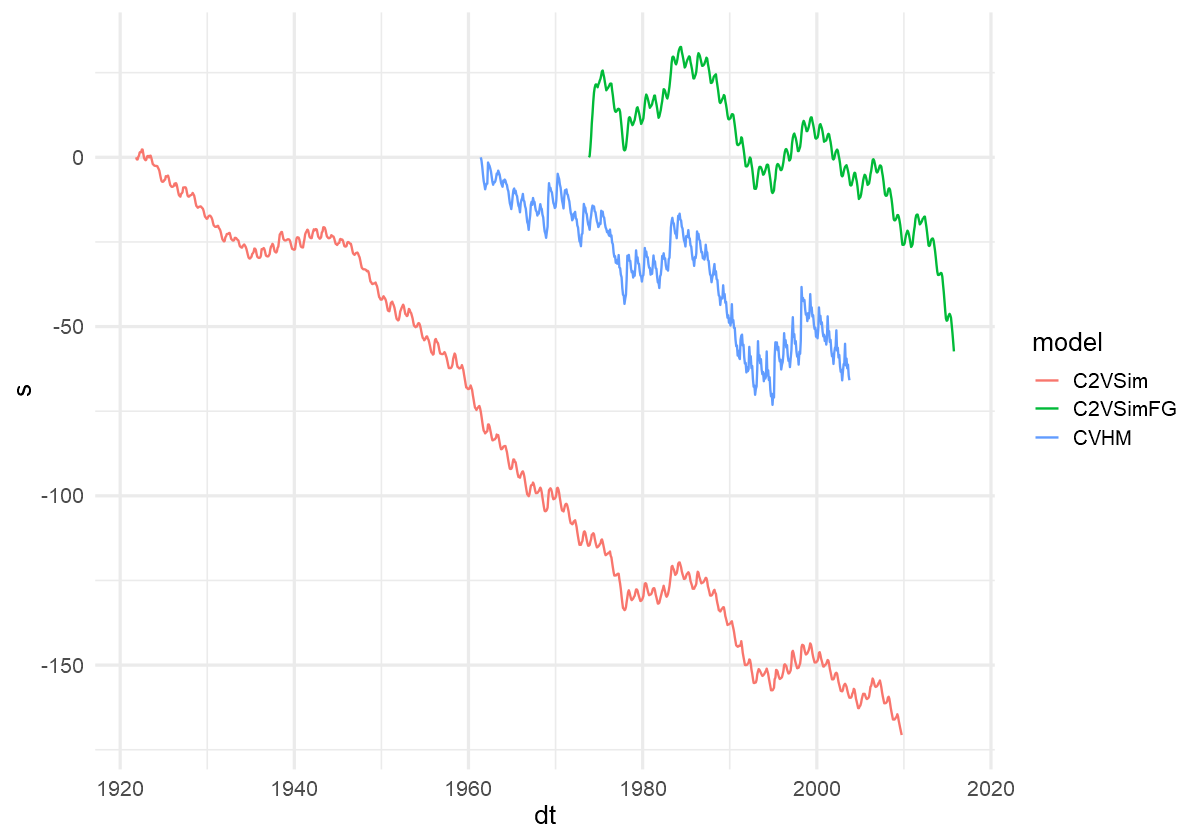

In [181]:
bind_rows(d1c, d2c, d3c) %>%
    ggplot(aes(dt, s, color = model)) +
    geom_line() + 
    theme_minimal(base_size = 15) 

### Therefore, we normalize all models to the the same time step (1974-07-31 UTC). We observe realtive agreement among the 3 models. 

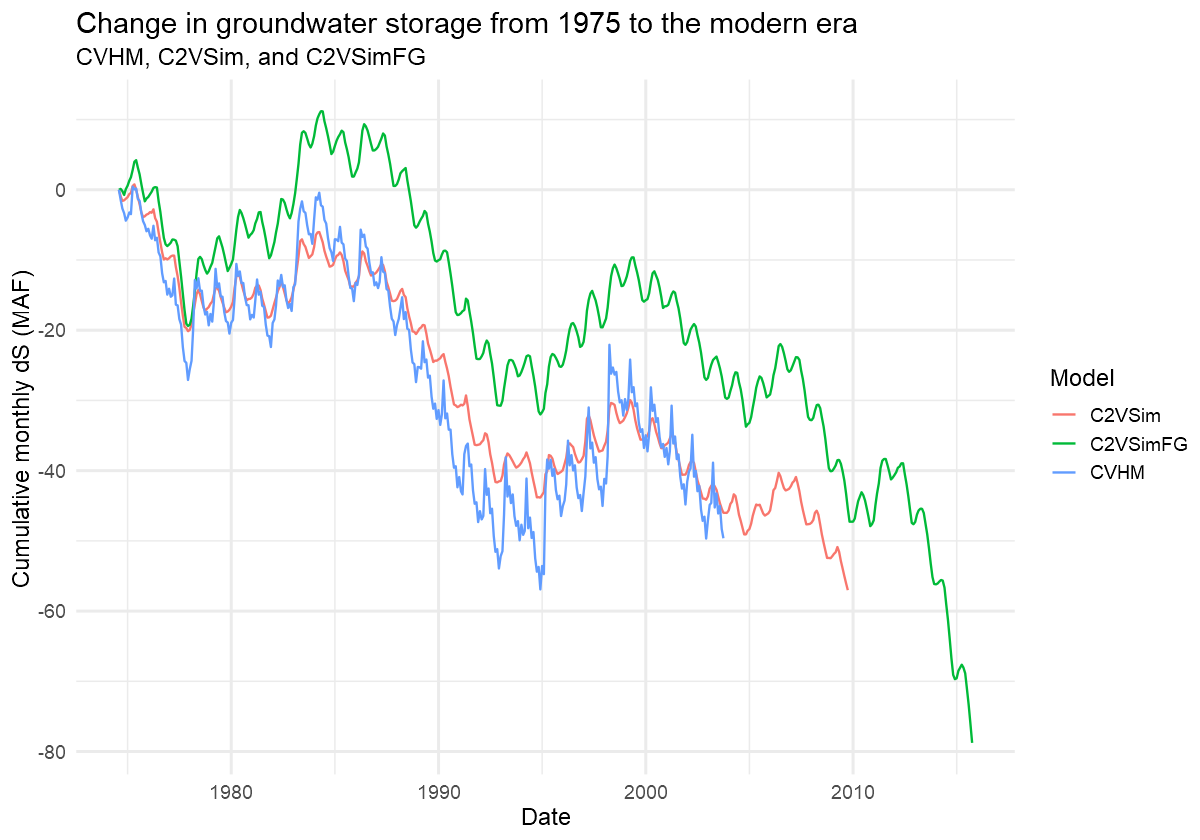

In [180]:
# start near the beginning of the C2VSimFG model, and ignore model spin up
start <- d1c$dt[10]

# normalize each model 
d1cn <- d1c %>% filter(dt >= start) %>% mutate(s = s - s[1])
d2cn <- d2c %>% filter(dt >= start) %>% mutate(s = s - s[1])
d3cn <- d3c %>% filter(dt >= start) %>% mutate(s = s - s[1])

# plot
bind_rows(d1cn, d2cn, d3cn) %>%
    #filter(dt >= d3c$dt[10]) %>%
    ggplot(aes(dt, s, color = model)) +
    geom_line() + 
    theme_minimal(base_size = 14) + 
    labs(title    = "Change in groundwater storage from 1975 to the modern era", 
         subtitle = "CVHM, C2VSim, and C2VSimFG",
         y = "Cumulative monthly dS (MAF)", x = "Date", color = "Model")

***  

# Sanity Check

The CVHM model report (Faunt et al., 2009) show below suggests a storage change of ~ 60 MAF from 1962 - 2003. Now compare that to the CVHM CV storage change shown in the next plot below.

![sfg](../data/faunt.png)

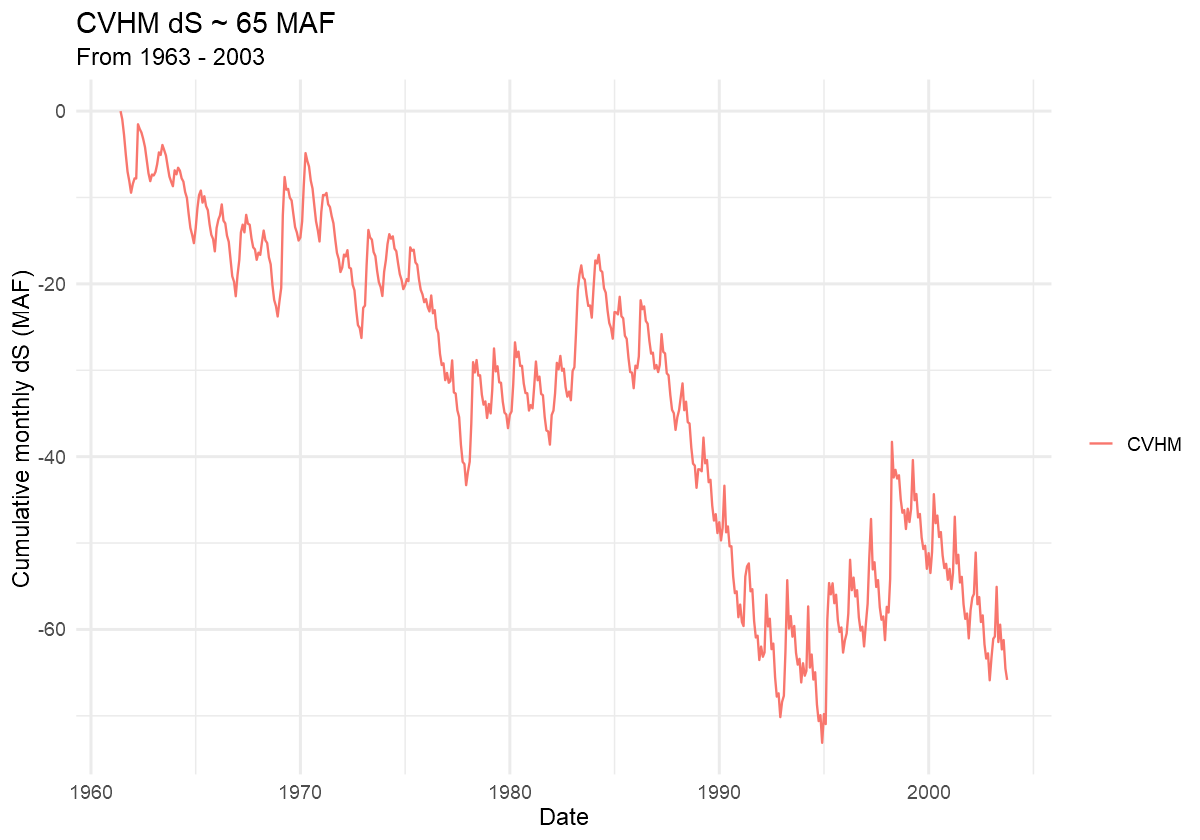

In [187]:
# plot
d3c %>%
    ggplot(aes(dt, s, color = model)) +
    geom_line() + 
    theme_minimal(base_size = 14) + 
    labs(title    = "CVHM dS ~ 65 MAF", subtitle = "From 1963 - 2003", 
         y = "Cumulative monthly dS (MAF)", x = "Date", color = "")

And the sanity check shows us that we're okay. If this timeseries was smoothed at the annual or 3-6 month range like appears to be in Faunt et al. (2009), we'd see exactly the same dS. Ours is a bit more rough since it's on a monthly time step.  

# Sanity Check: C2VSim

We repeat, but this time for C2VSim. Here's the dS figure from (Brush et al., 2013). Below is the dS figure that suggests a decrease of ~ 130 MAF in groundwater storage, this time from the period between 1922 and 2009. Below this plot, we show the data. 

![](../data/brush.png)


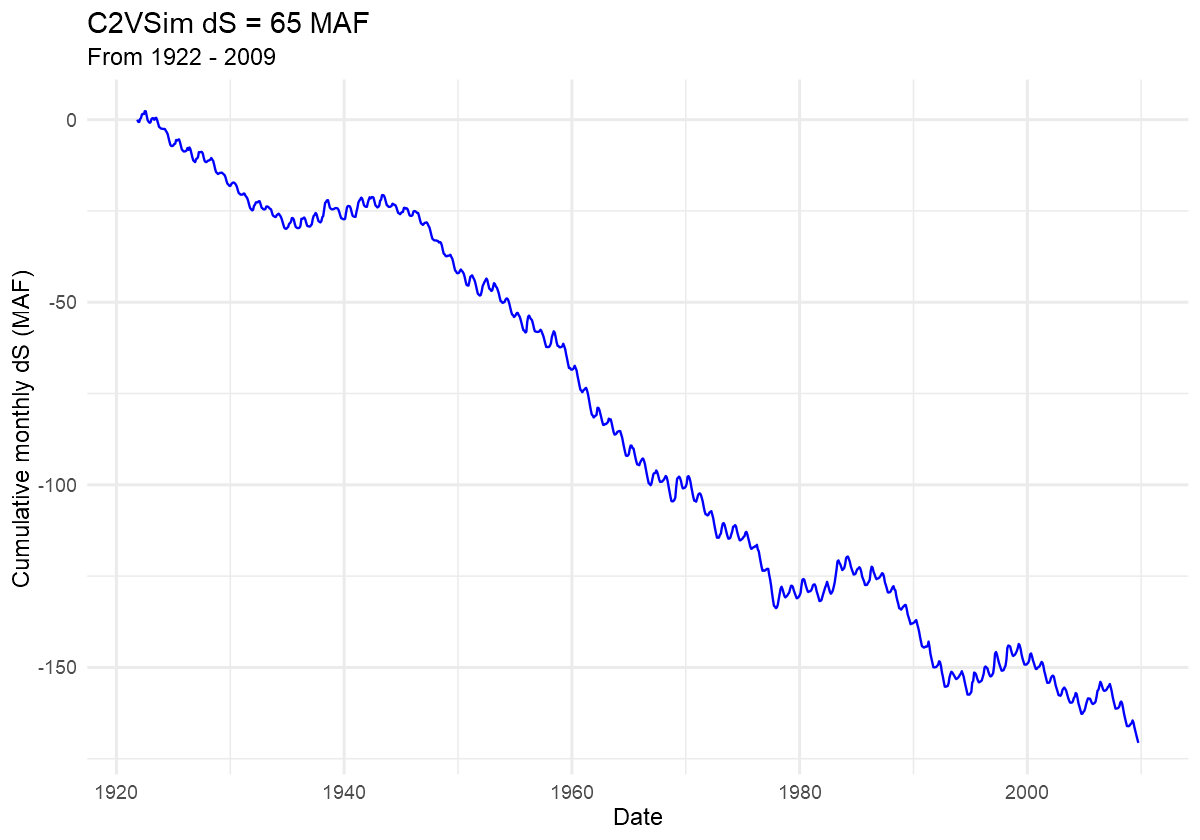

In [188]:
# plot
d2c %>%
    ggplot(aes(dt, s, color = model)) +
    geom_line(color = "blue") + 
    theme_minimal(base_size = 14) + 
    labs(title    = "C2VSim dS = 65 MAF", subtitle = "From 1922 - 2009", 
         y = "Cumulative monthly dS (MAF)", x = "Date", color = "")

And we observe 170 MAF instead of 130 MAF, which is about 40 MAF too much. I've sent an email to the C2VSim model developers to understand why we might be witnessing this difference. My suspicion is that the model files I'm using come from a later iteration of the model, and that the report is out of date, but we need to wait and see.  

I'm not as concerned about this difference, because there's tremendous uncertainty when reconstructing a groundwater budget as far back as 100 years, and in reltively modern times, from 1975 onward, there is agreement between the models. Nonetheless, since the C2VSim series fails the sanity check (doesn't line up with Brush et al. (2018)), I'm looking into this.  

Here's that model comparison once more:  

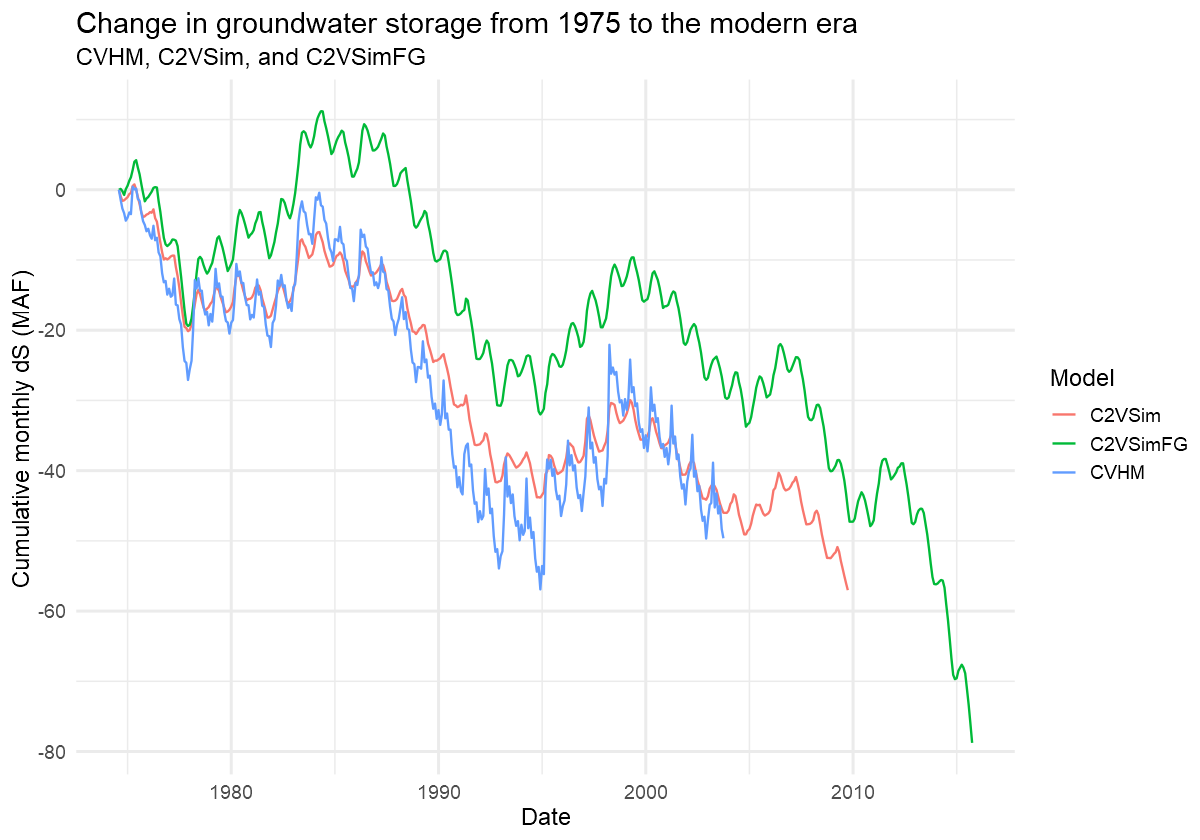

In [189]:
# plot
bind_rows(d1cn, d2cn, d3cn) %>%
    #filter(dt >= d3c$dt[10]) %>%
    ggplot(aes(dt, s, color = model)) +
    geom_line() + 
    theme_minimal(base_size = 14) + 
    labs(title    = "Change in groundwater storage from 1975 to the modern era", 
         subtitle = "CVHM, C2VSim, and C2VSimFG",
         y = "Cumulative monthly dS (MAF)", x = "Date", color = "Model")